### Output the Convective/Stratiform (C/S) Mask information for GridRad dBZ data.

**Apply the Convective & Stratiform separation algorithm on the GridRad data.**

**Using [Convective-Stratiform separation algorithm](https://github.com/yuhungjui/Modules_Py#readme)**

**For [GridRad - Three-Dimensional Gridded NEXRAD WSR-88D Radar Data](https://rda.ucar.edu/datasets/ds841.0/).**

**Hungjui Yu 20220221**

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
import sys
import time
import datetime as dt
import pytz
from netCDF4 import (Dataset, MFDataset)
import numpy as np
import xarray as xr
import pandas as pd
import wrf
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import matplotlib as mpl
import matplotlib.pyplot as plt

mod_path = '/glade/work/hungjui/Research_Test/Modules_Py/Conv_Stra_Mask'
if mod_path not in sys.path:
    sys.path.insert(0, mod_path)
    print(sys.path)
import conv_stra_mask as csm

mod_path = '/glade/work/hungjui/Research_Test/Modules_Py/GridRad/gridrad_python_software_v3'
if mod_path not in sys.path:
    sys.path.insert(0, mod_path)
    print(sys.path)
import gridrad_v3 as grd

['/glade/work/hungjui/Research_Test/Modules_Py/Conv_Stra_Mask', '/glade/work/hungjui/Research_Test/GridRad_Cloud_Classification/GridRad_Class_V31/Data_Process_CS_mask', '/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/lib/python37.zip', '/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/lib/python3.7', '/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/lib/python3.7/lib-dynload', '', '/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages', '/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/PyNIO', '/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/wrf_python-1.3.2-py3.7-linux-x86_64.egg', '/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/wrapt-1.12.1-py3.7-linux-x86_64.egg', '/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/pycuda-2020.1-py3.7-linux-x86_64.egg', '/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/Mako-1.1.3-py3.7.egg', 

<!-- #### Set input files paths and names: -->

In [3]:
def set_input_names(file_date):

    file_path_1_gridrad = '/gpfs/fs1/collections/rda/data/ds841.0'
    # file_path_1_gridrad = '/gpfs/fs1/collections/rda/data/ds841.1'
    file_path_2 = '/{}'.format(file_date.strftime('%Y%m'))

    file_pathnames = dict( dbz = file_path_1_gridrad
                               + file_path_2
                               + '/nexrad_3d_v' + '3_1_' + file_date_time.strftime('%Y%m%dT%H%M%SZ') + '.nc'
                               # + '/nexrad_3d_v' + '4_2_' + file_date_time.strftime('%Y%m%dT%H%M%SZ') + '.nc'
                         )

    
    return file_pathnames

file_date_time = dt.datetime(2011, 4, 27, 12, 0, 0, tzinfo=pytz.utc)
file_name_dict = set_input_names(file_date_time)
print(file_name_dict['dbz'])

/gpfs/fs1/collections/rda/data/ds841.0/201104/nexrad_3d_v3_1_20110427T120000Z.nc


#### Function: Read in GridRad data:

In [37]:
def read_gridrad_data(file_pathname):
    
    ## Read in the GridRad data from files:
    data = grd.read_file(file_pathname)
    data = grd.filter(data)
    data = grd.remove_clutter(data, skip_weak_ll_echo=1)
    # data = grd.remove_clutter(data, skip_weak_ll_echo=0)
    # plot = grd.plot_image(data)
    
    return data

# data_dict = read_gridrad_data(file_name_dict['dbz'])
# print(data_dict)
# data_dict = grd.filter(data_dict)
# data_dict = grd.remove_clutter(data_dict, skip_weak_ll_echo=1)
# test_plot = grd.plot_image(data_dict)
# data_dict.keys()
# data_dict['Z_H']['values'].shape

#### Function: Convective/Stratiform separation:

In [30]:
def CS_separation(refl, lat, lon):

    ## Convective/Stratiform separation:
    cs, cc, bkgnd = csm.conv_stra_sep(refl, lat, lon, 4, 'L', 'SHY')
    
    cs[np.where(refl <= 0.0)] = np.nan
    cs[np.where(np.isnan(refl))] = -1
    
    return cs


### Main Function:

In [31]:
def main_function(file_date_time):
    
    ## Set file datetime:
    # file_date_time = dt.datetime(2013, 9, 13, 0, 0, 0, tzinfo=pytz.utc)
    print('\nProcessing: {}'.format(file_date_time.strftime('%Y%m%d')), end=': ')
    
    ## Set input files paths and names:
    file_name_dict = set_input_names(file_date_time)

    ## Get the 3-hourly time list:
    nc_wrf_dbz = Dataset(file_name_dict['dbz'], mode='r')
    wrf_3hour_list = wrf.extract_times(nc_wrf_dbz, timeidx=wrf.ALL_TIMES, meta=False, do_xtime=False)
    nc_wrf_dbz.close()
    
    ## Open dBZ data array and append calculated data:
    ds_wrf_dbz = xr.open_dataset(file_name_dict['dbz'])
    
    ## Set sigma level index:
    interp_vertical_lev = 12 # number in levels.
    
    for hi in range(len(wrf_3hour_list)):
        
        print(str(hi) + ' | ', end=' ')

        ## Get dBZ data:
        da_wrf_dbz = ds_wrf_dbz['dBZ'].isel(Time=hi)
        
        ## Get dBZ data at specified sigma level:
        dbz_sigmalev = da_wrf_dbz[interp_vertical_lev,:,:]
        
        ## Convective/Stratiform Separation:
        ## !!! Make sure the array for the masking is in numpy array format (speed issue) !!!
        CS_mask_single = CS_separation( dbz_sigmalev.data
                                      , dbz_sigmalev.XLAT.data
                                      , dbz_sigmalev.XLONG.data
                                      )
        
        ## Stack the CS mask according to hours:
        if ( hi == 0 ):
            # CS_mask = CS_mask_single
            CS_mask = np.expand_dims(CS_mask_single, axis=0)
        else:
            # CS_mask = xr.concat([CS_mask, CS_mask_single], dim='TimeDim')
            CS_mask = np.append(CS_mask, np.expand_dims(CS_mask_single, axis=0), axis=0)
            
        # print(type(CS_mask))
        # print(CS_mask.shape)
        
    ## Add CS mask to dBZ dataset:
    # ds_wrf_dbz['CS_mask'] = (['Time', 'south_north', 'west_east'], CS_mask)
    
    ## Add attributes to dBZ and Convective/Stratiform mask:
    # ds_wrf_dbz.CS_mask.attrs['long_name'] = 'Convective/Stratiform Mask'
    # ds_wrf_dbz.CS_mask.attrs['description'] = 'Derived mask for convective (1-5) and stratiform (0) echos at sigma level: 12'
    
    ## Save to NetCDF file:
    # ds_wrf_dbz.to_netcdf(file_name_dict['dbz'],'a')
    # ds_wrf_dbz.to_netcdf('./test.nc')
    
    ds_wrf_dbz.close()
    
    ## Save & Update to NetCDF file:
    nc_wrf_dbz = Dataset(file_name_dict['dbz'], mode='r+')
    
    nc_wrf_dbz['CS_mask'][:] = CS_mask
    nc_wrf_dbz['CS_mask'].description = 'Derived mask for convective (1-5) and stratiform (0) echos at sigma level: 12'

    nc_wrf_dbz.close()

    # return CS_mask



### Main Program:

In [32]:
start = time.time()


## WRF Model Simulation Category:
wrf_sim_type = 'CTRL3D'
# wrf_sim_type = 'PGW3D'

## Loop through a period:
target_date_range = pd.date_range(start='2005-10-25', end='2005-10-25', tz=pytz.utc)

for dayi in target_date_range:
        
    ## Derive Convective/Stratiform mask and Update the NetCDF file:
    main_function(dayi)

    
end = time.time()

print("\nRUNTIME：%f SEC" % (end - start))
print("\nRUNTIME：%f MIN" % ((end - start)/60))
print("\nRUNTIME：%f HOUR" % ((end - start)/3600))
    


Processing: 20051025: 0 |  1 |  2 |  3 |  4 |  5 |  6 |  7 |  
RUNTIME：3.618760 SEC

RUNTIME：0.060313 MIN

RUNTIME：0.001005 HOUR


In [7]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


#### <font color='teal'>**Supplement Codes:**</font>

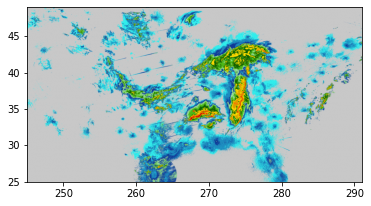

In [5]:
data = grd.read_file(file_name_dict['dbz'])
plot = grd.plot_image(data)

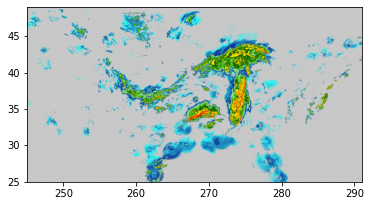

In [6]:
data = grd.read_file(file_name_dict['dbz'])
data = grd.filter(data)
plot = grd.plot_image(data)

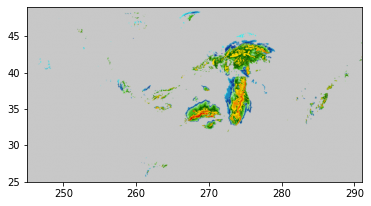

In [7]:
data = grd.read_file(file_name_dict['dbz'])
data = grd.filter(data)
data = grd.remove_clutter(data, skip_weak_ll_echo=0)
plot = grd.plot_image(data)

#### <font color='teal'>**Function: creating new map:**</font>

In [35]:
def new_map(fig):
    
    # proj = ccrs.LambertConformal()
    proj = ccrs.PlateCarree(central_longitude=0)
    
    # ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax = plt.axes(projection=proj)
    
    ## Set extent:
    # ax.set_global()
    
    ## CONUS:
    ax.set_extent([-139, -55, 16, 60], crs=proj)    
    ## 9/13 case:
    # ax.set_extent([-115, -95, 32, 43], crs=proj)    
    ## 4/27 case:
    # ax.set_extent([-96, -84, 33, 41], crs=proj)
    ## Test:
    # ax.set_extent([-86, -76, 25, 33], crs=proj)
    ax.set_extent([-86, -65, 25, 45], crs=proj)
    
    ## Add coast lines:
    ax.coastlines('10m', 'black', linewidth=1)
    
    ## Add features:
    ax.add_feature(cfeat.BORDERS)
    ax.add_feature(cfeat.OCEAN, edgecolor=None, fc='none')
    
    ## Grab state shapefile:
    state_borders = cfeat.NaturalEarthFeature(category='cultural', 
                                              name='admin_1_states_provinces_lines', 
                                              scale='110m', 
                                              facecolor='none',
                                              edgecolor='k'
                                             )
    
    ax.add_feature(state_borders, linewidth=0.8)
    
    ## Add the gridlines:
    latlon_grid_int = 5
    ax_gl = ax.gridlines(crs=ccrs.PlateCarree()
                        ,linewidth=0.5
                        ,color='#454545' 
                        ,alpha=0.9
                        ,linestyle='--'
                        ,draw_labels=True 
                        ,dms=True
                        ,x_inline=False 
                        ,y_inline=False
                        ,xlocs=np.arange(-180, 181, latlon_grid_int)
                        ,ylocs=np.arange(-90, 91, latlon_grid_int)
                        )
    ax_gl.top_labels = False
    ax_gl.right_labels = False
    ax_gl.bottom_labels = True
    ax_gl.left_labels = True
    ax_gl.xlabel_style = {'size': 12, 'weight': 'bold'}
    ax_gl.ylabel_style = {'size': 12, 'weight': 'bold'}
    
    
    return ax

#### <font color='teal'>**Do the plot:**</font>

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


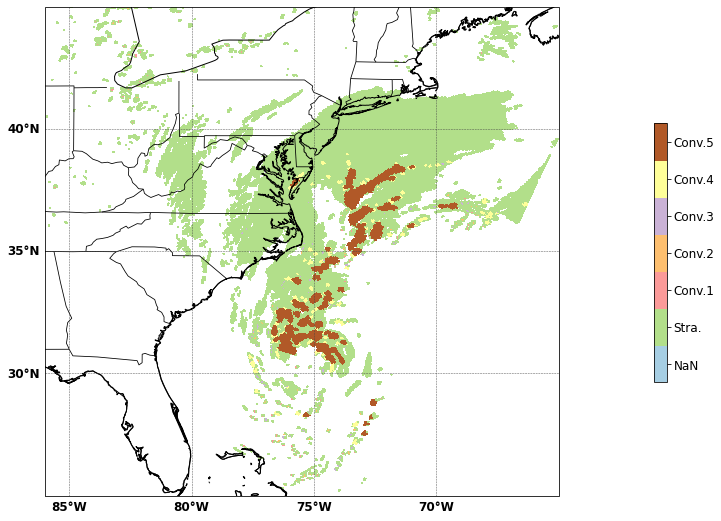

In [36]:
## Open file:
file_date_time = dt.datetime(2005, 10, 25, 0, 0, 0, tzinfo=pytz.utc)
file_name_dict = set_input_names(file_date_time)
ds_wrf_dbz = xr.open_dataset(file_name_dict['dbz'])


fig = plt.figure(figsize=(12,9))
ax1 = new_map(fig)
# ax1 = plt.axes(projection = ccrs.LambertConformal(central_longitude=-100, central_latitude=40))
# ax1 = plt.axes(projection = ccrs.PlateCarree())

# cs[cs<0] = np.nan
# cc[cc<0] = np.nan

# plotting_var = cs
plotting_var = ds_wrf_dbz.CS_mask[0]
plotting_lon = ds_wrf_dbz.XLONG
plotting_lat = ds_wrf_dbz.XLAT

cf1 = ax1.pcolormesh( plotting_lon, plotting_lat, plotting_var
                    , cmap=plt.cm.get_cmap('Paired', 7)
                    , vmin=-1
                    , vmax=5
                    , shading='auto'
                    )
cf1.cmap.set_under('w')

## Colorbar:
cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])
cbar = fig.colorbar(cf1, 
                    cax=cbar_ax, 
                    fraction=0.04, 
                    ticks=np.arange(-1, 6, 1), 
                    boundaries=np.arange(-1.5, 6.5, 1))
cbar.ax.tick_params(labelsize=12)
cbar.set_ticklabels(['NaN', 'Stra.', 'Conv.1', 'Conv.2', 'Conv.3', 'Conv.4', 'Conv.5'])
# cbar_title = plt.title('[dBZ]', fontsize=12, y=-0.1)
